In [1]:
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torchinfo

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset

In [2]:
def create_dataloader(dataset, transform=None, val_split=0.25, batch_size=64, num_workers=2):
    train_set = dataset('./data', train=True,  download=True, transform=transform)
    test_set  = dataset('./data', train=False, download=True, transform=transform)
    
    train_set, val_set = torch.utils.data.random_split(train_set, [1-val_split, val_split])
    
    train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val   = torch.utils.data.DataLoader(val_set,   batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    test  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return (train, val, test)

# Create model

## Gradient Reversal Layer

In [3]:
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

## CNN

In [4]:
class DomainClassifier(nn.Module):
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        
        self.projection = nn.Linear(in_features, hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=1), num_layers=1
        )
        self.op_layer = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.projection(x)
        x = self.transformer(x)[0, :]
        x = self.op_layer(x)
        return x

In [5]:
class KRegressor(nn.Module):
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        
        self.projection = nn.Linear(in_features, hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size * 2,
                nhead=1
            ),
            num_layers=1
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, xs: torch.Tensor, xt: torch.Tensor) -> torch.Tensor:
        xs1 = self.projection(xs)
        xt1 = self.projection(xt)
        x_combined = torch.cat((xs1, xt1), dim=1)
        z = self.transformer(x_combined)[0, :]
        k = self.output_layer(z)
        return k

In [6]:
class MyModel(nn.Module):
    def __init__(
        self,
        input_shape:       Tuple[int],
        output_shape:      int,
        cnn_out_features:  List[int],
        fnn_out_features:  List[int],
        batch_size:        int,
        beta: float = 5,
        esp:  float = 1e-8,
    ):
        super().__init__()
        
        self.input_shape  = input_shape
        self.output_shape = output_shape
        self.cnn_layers = nn.ModuleList()
        self.fnn_layers = nn.ModuleList()
        
        self.beta = beta
        self.esp  = esp
        
        shape = list(input_shape)
        prev_nf = input_shape[0]
        
        i = 0
        for curr_nf in cnn_out_features:
            self.cnn_layers.append(nn.Sequential(
                nn.Conv2d(prev_nf, curr_nf, kernel_size=3, padding='same'),
                nn.MaxPool2d(2)
            ))
            prev_nf = curr_nf
            
            shape[0] = curr_nf
            shape[1] = int(shape[1] / 2)
            shape[2] = int(shape[2] / 2)
        
        prev_nf = shape[0] * shape[1] * shape[2]
        
        self.k_regressor = KRegressor(prev_nf, hidden_size=128)
        self.domain_classifier = DomainClassifier(prev_nf, hidden_size=128)
        
        for curr_nf in fnn_out_features:
            self.fnn_layers.append(nn.Sequential(
                nn.Linear(prev_nf, curr_nf),
                nn.ReLU()
            ))
            prev_nf = curr_nf
        
        self.op_layer = nn.Sequential(nn.Linear(prev_nf, output_shape))
    
    def forward(self, xs: torch.Tensor, xt: torch.Tensor, alpha: float) -> Tuple[torch.Tensor]:
        # feature extraction
        for layer in self.cnn_layers:
            xs = layer(xs)
            xt = layer(xt)
        xs = torch.flatten(xs, start_dim=1)
        xt = torch.flatten(xt, start_dim=1)
        
        # dimensionality reduction & alignment
        k  = self.k_regressor(xs, xt)
        kd = min(xs.shape[0], xs.shape[1])
        
        xs = xs - torch.mean(xs, dim=0)
        xs = xs + self.esp
        us, ss, vhs = torch.linalg.svd(xs, full_matrices=True)
        
        xt = xt - torch.mean(xt, dim=0)
        xt = xt + self.esp
        ut, st, vht = torch.linalg.svd(xt, full_matrices=True)
        
        i = torch.arange(kd, device=xs.device)
        weights = torch.sigmoid(-self.beta*(i - k*kd))
        
        ss1 = torch.diag(ss * weights)
        ss1 = torch.cat((ss1, torch.zeros((xs.shape[0] - kd, kd), device=xs.device)), dim=0)
        ss1 = torch.cat((ss1, torch.zeros((xs.shape[0], xs.shape[1] - kd), device=xs.device)), dim=1)
        xs = torch.mm(torch.mm(us, ss1), vhs)
        # xs = torch.mm(us, ss1)
        
        st1 = torch.diag(ss * weights)
        st1 = torch.cat((st1, torch.zeros((xt.shape[0] - kd, kd), device=xt.device)), dim=0)
        st1 = torch.cat((st1, torch.zeros((xt.shape[0], xt.shape[1] - kd), device=xt.device)), dim=1)
        # xt = torch.mm(torch.mm(ut, st1), vht)
        # xt = torch.mm(us, ss1)
        
        # project xs onto the principal direction of xt
        weights = torch.cat((weights, torch.zeros((xt.shape[1] - kd,), device=xt.device)), dim=0)
        vht1 = vht * weights
        xs = torch.mm(xs, vht1.T)
        # xt = torch.mm(xt, vht1.T)
        
        # domain classification
        xs_reverse = ReverseLayerF.apply(xs, alpha)
        ys_domain = self.domain_classifier(xs_reverse)
        
        xt_reverse = ReverseLayerF.apply(xt, alpha)
        yt_domain = self.domain_classifier(xt_reverse)
        
        # class regression
        for layer in self.fnn_layers:
            xs = layer(xs)
            xt = layer(xt)
        
        ys_class = xs
        yt_class = xt
        return (ys_class, ys_domain, yt_class, yt_domain, k)

# Create model

## Customized loss

In [7]:
class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dummy_param = nn.Parameter(torch.empty(0))
        self.loss_class  = nn.CrossEntropyLoss()
        self.loss_domain = nn.BCELoss()
    
    def forward(self, ys_class, ys_class_true, ys_domain, yt_domain):
        ys_domain_true = torch.zeros(1, device=self.dummy_param.device)
        yt_domain_true = torch.ones(1, device=self.dummy_param.device)
        
        loss_s_class  = self.loss_class(ys_class, ys_class_true)
        loss_s_domain = self.loss_domain(ys_domain, ys_domain_true)
        loss_t_domain = self.loss_domain(yt_domain, yt_domain_true)
        
        loss = loss_s_class + loss_s_domain + loss_t_domain
        return (loss, loss_s_class, loss_s_domain, loss_t_domain)

# Training & evaluation

In [8]:
def evaluate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    mode: str = None,
):
    model.eval()
    val_losses = []
    val_class_losses  = []
    val_domain_losses = []
    val_pt = []
    accuracy = 0
    
    with torch.no_grad():
        for batch_idx, (x, y_true) in enumerate(dataloader):
            x = x.to(device)
            y_true = y_true.to(device)
            
            if x.shape[0] != batch_size:
                continue
            
            ys_class, ys_domain, yt_class, yt_domain, k = model(x, x, 0)
            y_pred = ys_class
            loss, loss_s_class, loss_s_domain, loss_t_domain = loss_fn(y_pred, y_true, ys_domain, yt_domain)
            
            val_losses += [loss.item()]
            val_class_losses  += [loss_s_class.item()]
            val_domain_losses += [loss_s_domain.item()]
            val_pt += [ys_domain.item()]
            
            y_pred1 = torch.max(y_pred, dim=1)[1]
            accuracy += torch.sum(y_pred1 == y_true).item()
    
    accuracy /= len(dataloader.dataset)
    loss        = np.mean(val_losses)
    class_loss  = np.mean(val_class_losses)
    domain_loss = np.mean(val_domain_losses)
    
    if mode is not None:
        print('{} -> loss: {:.6f}\tloss_class: {:.6f}\tloss_domain: {:.6f}\tp(t|x): {:.6f}\taccuracy: {:.4f}%'.format(
            mode,
            loss,
            class_loss,
            domain_loss,
            ys_domain.item(),
            accuracy * 100
        ))
    return (loss, class_loss, domain_loss, accuracy)

In [9]:
def train(
    model: nn.Module,
    dataloader_s: torch.utils.data.DataLoader,
    dataloader_t: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    epoch:      int,
    num_epochs: int,
    checkpoint: int = None
):
    model.train()
    losses = []
    losses_s_class  = []
    losses_s_domain = []
    losses_t_domain = []
    
    len_dataloader = min(len(dataloader_s), len(dataloader_t))
    iter_s = iter(dataloader_s)
    iter_t = iter(dataloader_t)

    for batch_idx in range(len_dataloader):
        p = float(batch_idx + epoch * len_dataloader) / num_epochs / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        alpha = 0.1*alpha

        data_s = next(iter_s)
        data_t = next(iter_t)

        xs, ys_true = data_s
        xt, yt_true = data_t
        xs = xs.to(device)
        xt = xt.to(device)
        ys_true = ys_true.to(device)
        yt_true = yt_true.to(device)
        
        if xs.shape[0] != xt.shape[0]:
            continue

        ys_class, ys_domain, yt_class, yt_domain, k = model(xs, xt, alpha)
        loss, loss_s_class, loss_s_domain, loss_t_domain = loss_fn(ys_class, ys_true, ys_domain, yt_domain)
        loss = loss_s_class + loss_s_domain + loss_t_domain + 1e-2*k

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += [loss.item()]
        losses_s_class  += [loss_s_class.item()]
        losses_s_domain += [loss_s_domain.item()]
        losses_t_domain += [loss_t_domain.item()]

        if checkpoint is not None and batch_idx % checkpoint == 0:
            print('Train -> [{:>5}/{:>5} ({:.0f}%)]\tloss: {:.6f}\tloss_s_class: {:.6f}\tloss_domain: {:.6f}+{:.6f}\tp(t|s): {:.6f}\tp(t|t): {:.6f}'.format(
                batch_idx * dataloader_s.batch_size,
                len_dataloader * dataloader_s.batch_size,
                batch_idx / len_dataloader * 100,
                loss.item(),
                loss_s_class.item(),
                loss_s_domain.item(),
                loss_t_domain.item(),
                ys_domain.item(),
                yt_domain.item()
            ))
            print(k.item())
    
    loss = np.mean(losses)
    loss_s_class  = np.mean(losses_s_class)
    loss_s_domain = np.mean(losses_s_domain)
    loss_t_domain = np.mean(losses_t_domain)
    
    return (loss, loss_s_class, loss_s_domain, loss_t_domain)

# Plotting

In [10]:
def plot_losses(
    losses: List[np.ndarray],
    labels: List[str] = None,
    ylabel: str = '',
    xlabel: str = '',
    title:  str = ''
):
    if labels is None:
        labels = [''] * len(losses)
    for loss, label in zip(losses, labels):
        plt.plot(loss, label=label)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

# Main

In [11]:
lr         = 1e-3
batch_size = 128
num_epochs = 100
checkpoint = 100
model_save_path = 'best_model.pt'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_s, val_s, test_s = create_dataloader(
    torchvision.datasets.MNIST,
    transform=transform,
    batch_size=batch_size
)
train_t, val_t, test_t = create_dataloader(
    torchvision.datasets.USPS,
    transform=transforms.Compose([transform, transforms.Resize((28, 28))]),
    batch_size=batch_size
)

In [12]:
# img_s = next(iter(train_s))[0][0]
# print(img_s.shape)
# plt.imshow(img_s[0], cmap='gray')
# plt.show()

# img_t = next(iter(train_t))[0][0]
# print(img_t.shape)
# plt.imshow(img_t[0], cmap='gray')
# plt.show()

In [13]:
model = MyModel(
    input_shape=(1, 28, 28),
    output_shape=10,
    cnn_out_features=[16, 32, 64],
    fnn_out_features=[128, 64],
    batch_size=batch_size
).to(device)

loss_fn    = MyLoss().to(device)
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = [[], [], [], []]
val_s_losses = [[], [], [], []]
val_t_losses = [[], [], [], []]
train_loss_labels  = ['loss', 'loss_s_class', 'loss_s_domain', 'loss_t_domain']
val_loss_labels    = ['loss', 'loss_class', 'loss_domain', 'accuracy']

In [14]:
torchinfo.summary(
    model,
    input_size=[(batch_size, 1, 28, 28), (batch_size, 1, 28, 28), (1,)]
)

Layer (type:depth-idx)                             Output Shape              Param #
MyModel                                            [128, 64]                 650
├─ModuleList: 1-1                                  --                        --
│    └─Sequential: 2-1                             [128, 16, 14, 14]         --
│    │    └─Conv2d: 3-1                            [128, 16, 28, 28]         160
│    │    └─MaxPool2d: 3-2                         [128, 16, 14, 14]         --
│    └─Sequential: 2-2                             [128, 16, 14, 14]         (recursive)
│    │    └─Conv2d: 3-3                            [128, 16, 28, 28]         (recursive)
│    │    └─MaxPool2d: 3-4                         [128, 16, 14, 14]         --
│    └─Sequential: 2-3                             [128, 32, 7, 7]           --
│    │    └─Conv2d: 3-5                            [128, 32, 14, 14]         4,640
│    │    └─MaxPool2d: 3-6                         [128, 32, 7, 7]           --
│    └─Seque

In [15]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} --------')
    
    losses = train(model, train_s, train_t, loss_fn, optimizer, epoch, num_epochs, checkpoint=20)
    for i, loss in enumerate(losses):
        train_losses[i] += [loss]
    
    losses = evaluate(model, val_s, loss_fn, mode='Validation (source)')
    for i, loss in enumerate(losses):
        val_s_losses[i] += [loss]
    
    losses = evaluate(model, val_t, loss_fn, mode='Validation (target)')
    for i, loss in enumerate(losses):
        val_t_losses[i] += [loss]
    
    if losses[1] < best_val_loss:
        torch.save(model.state_dict(), model_save_path)
        best_val_loss = losses[1]
        print(f'Best model updated and saved at "{model_save_path}"')

Epoch 1 --------
Train -> [    0/ 5504 (0%)]	loss: 5.564973	loss_s_class: 4.150165	loss_domain: 0.917208+0.491692	p(t|s): 0.600367	p(t|t): 0.611591
0.5909112691879272
Train -> [ 2560/ 5504 (47%)]	loss: 4.156865	loss_s_class: 4.114511	loss_domain: 0.029646+0.012707	p(t|s): 0.029211	p(t|t): 0.987374
0.0001326416531810537
Train -> [ 5120/ 5504 (93%)]	loss: 4.070899	loss_s_class: 4.064340	loss_domain: 0.003475+0.003084	p(t|s): 0.003469	p(t|t): 0.996921
0.00011948696919716895
Validation (source) -> loss: 4.067337	loss_class: 4.055599	loss_domain: 0.002566	p(t|x): 0.002564	accuracy: 9.2400%
Validation (target) -> loss: 4.092357	loss_class: 4.065642	loss_domain: 0.002569	p(t|x): 0.002560	accuracy: 7.8485%
Best model updated and saved at "best_model.pt"
Epoch 2 --------
Train -> [    0/ 5504 (0%)]	loss: 4.063092	loss_s_class: 4.050678	loss_domain: 0.004667+0.007746	p(t|s): 0.004656	p(t|t): 0.992284
0.00010791631211759523
Train -> [ 2560/ 5504 (47%)]	loss: 3.976263	loss_s_class: 3.970128	loss_d

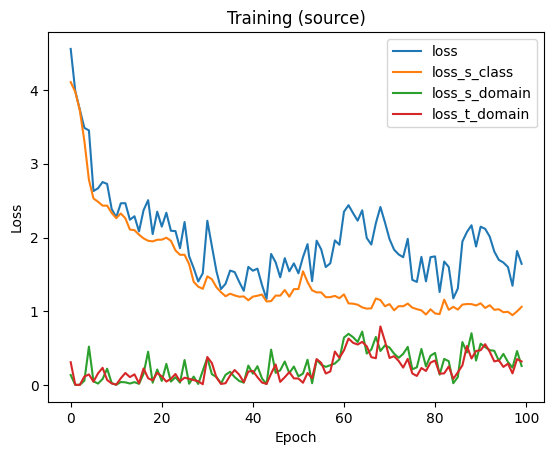

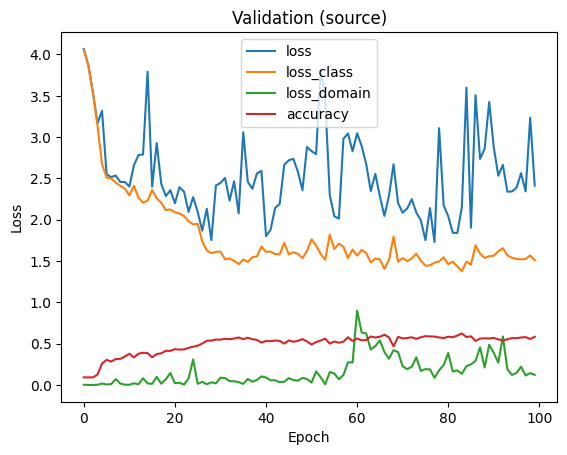

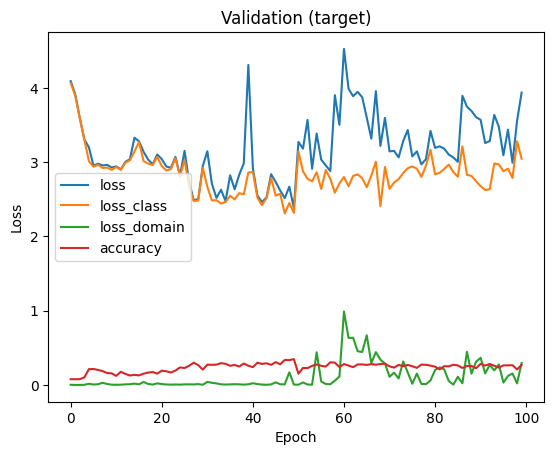

In [16]:
plot_losses(
    train_losses,
    train_loss_labels,
    ylabel='Loss',
    xlabel='Epoch',
    title='Training (source)'
)
plot_losses(
    val_s_losses,
    val_loss_labels,
    ylabel='Loss',
    xlabel='Epoch',
    title='Validation (source)'
)
plot_losses(
    val_t_losses,
    val_loss_labels,
    ylabel='Loss',
    xlabel='Epoch',
    title='Validation (target)'
)

In [17]:
model.load_state_dict(torch.load(model_save_path))
evaluate(model, test_s, loss_fn, mode='Test (source)')
evaluate(model, test_t, loss_fn, mode='Test (target)')

Test (source) -> loss: 2.584180	loss_class: 1.561904	loss_domain: 0.081521	p(t|x): 0.008472	accuracy: 54.3100%
Test (target) -> loss: 2.739450	loss_class: 2.433279	loss_domain: 0.009663	p(t|x): 0.008533	accuracy: 26.8062%


(2.739449874560038,
 2.4332788070042928,
 0.009663225089510282,
 0.268061783756851)